### ENIT 2024-2025
# Segmentation des clients du centre commercial: Clustering et analyse
### Élève ingénieur : Lekehal Hammada
### Classe : 3AGI1+NePRev

# 1. Importing the libraries

In [4]:
### Transformation des données

import numpy as np
import pandas as pd
import missingno
from collections import Counter

### Visualisation des données

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from tabulate import tabulate

###Projection
from sklearn.decomposition import PCA

### Supprimer les avertissements inutiles

import warnings
warnings.filterwarnings('ignore')

# 2. Importing the data

In [5]:
dataset = pd.read_csv("C:\\Users\\Youba\\Desktop\\Cours ML ENIT\Mall_Customers.csv")

In [6]:
dataset.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [4]:
dataset.shape

(200, 5)

Le jeu de données se compose de 5 colonnes et de 200 lignes.

# 3. Exploratory Data Analysis (EDA)

L'Analyse Exploratoire des Données (Exploratory Data Analysis - EDA) fait référence au processus essentiel consistant à mener des investigations initiales sur les données afin de découvrir des motifs, repérer des anomalies, tester des hypothèses et vérifier des hypothèses à l'aide de statistiques descriptives et de représentations graphiques.

Ici, nous effectuerons une EDA sur les colonnes catégoriques du jeu de données - Genre, et sur les colonnes numériques du jeu de données - Âge, Revenu Annuel (k$) et Score de Dépense (1-100).

#### 3.1 Datatypes, Missing Data, and Summary Statistics

In [5]:
### Looking at the datatypes of the dataset

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Ici, la colonne **Genre** est catégorique. Par conséquent, nous modifierons le type de données de cette colonne en **catégorie**.

In [7]:
### Changing the datatype of the column - Gender to category

dataset.Pclass = dataset.Gender.astype('category')

In [7]:
### Looking at the modified datatypes of the dataset

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Ici, nous pouvons constater qu'il n'y a aucune valeur manquante dans les colonnes.

In [8]:
### Summary statistics of the numerical columns in the dataset

dataset.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


#### 3.2 Feature Analysis

In [8]:
### Understanding the distribution of the numerical column

def diagnostic_plots(df, variable):
    plt.figure(figsize = (16, 4))

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins = 30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist = "norm", plot = plt)
    plt.ylabel('Variable quantiles')

    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y = df[variable])
    plt.title('Boxplot')

    plt.show()

##### 3.2.1 Categorical variable - Gender

In [9]:
### Value counts of the column - Gender

gender_count = dataset['Gender'].value_counts(dropna = False)
gender_count

Female    112
Male       88
Name: Gender, dtype: int64

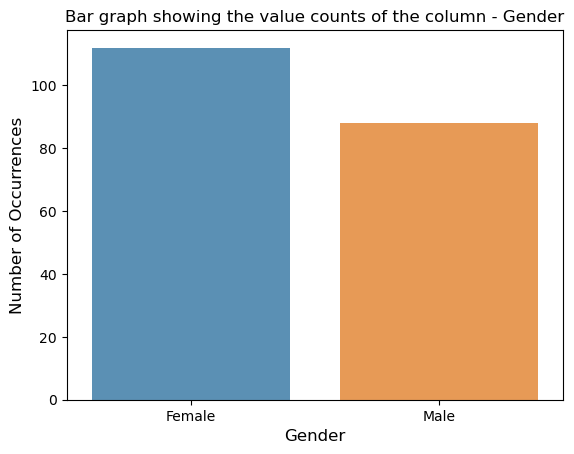

In [10]:
### Bar graph showing the value counts of the column - Gender

sns.barplot(x=gender_count.index, y=gender_count.values, alpha=0.8)
plt.title('Bar graph showing the value counts of the column - Gender')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que la majorité des clients du centre commercial sont des femmes. Voyons maintenant le revenu annuel moyen pour chaque genre.

In [11]:
### Mean of Annual Income by Gender

gender_income = dataset[['Gender', 'Annual Income (k$)']].groupby('Gender', as_index = False).mean()
gender_income

,Gender,Annual Income (k$)
0,Female,59.250000
1,Male,62.227273


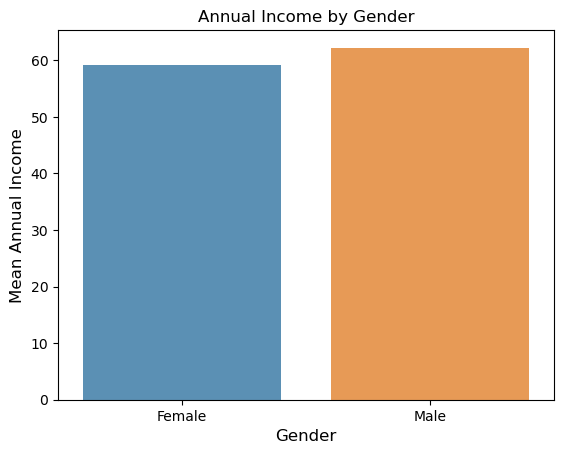

In [12]:
### Mean Annual Income by Gender

sns.barplot(x=gender_income['Gender'], y=gender_income['Annual Income (k$)'], alpha = 0.8)
plt.title('Annual Income by Gender')
plt.ylabel('Mean Annual Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que le revenu annuel moyen est presque similaire pour les hommes et les femmes.

In [14]:
### Mean Spending Score by Gender

gender_score = dataset[['Gender', 'Spending Score (1-100)']].groupby('Gender', as_index = False).mean()
gender_score

,Gender,Spending Score (1-100)
0,Female,51.526786
1,Male,48.511364


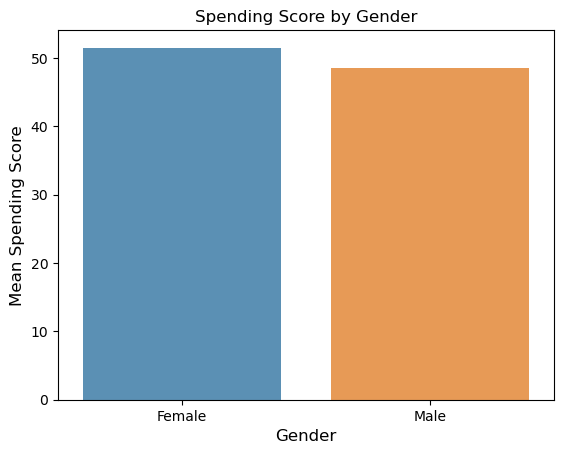

In [15]:
### Mean Spending Score by Gender

sns.barplot(x=gender_score['Gender'], y=gender_score['Spending Score (1-100)'], alpha = 0.8)
plt.title('Spending Score by Gender')
plt.ylabel('Mean Spending Score', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que le score moyen de dépense est légèrement plus élevé chez les femmes que chez les hommes.

In [16]:
### Mean Age by Gender

gender_age = dataset[['Gender', 'Age']].groupby('Gender', as_index = False).mean()
gender_age

,Gender,Age
0,Female,38.098214
1,Male,39.806818


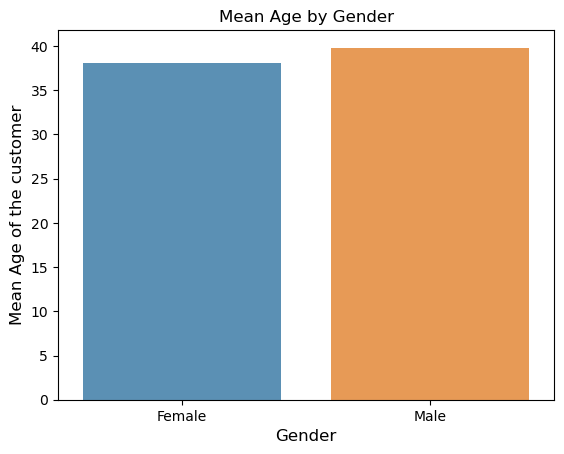

In [17]:
### Mean Age by Gender

sns.barplot(x=gender_age['Gender'], y=gender_age['Age'], alpha = 0.8)
plt.title('Mean Age by Gender')
plt.ylabel('Mean Age of the customer', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que l'âge moyen est légèrement plus élevé chez les clients masculins que chez les clientes féminines.

In [18]:
#Mtrice de correlation
correlations = dataset[['Age','Annual Income (k$)','Spending Score (1-100)']].corr()

<Axes: >

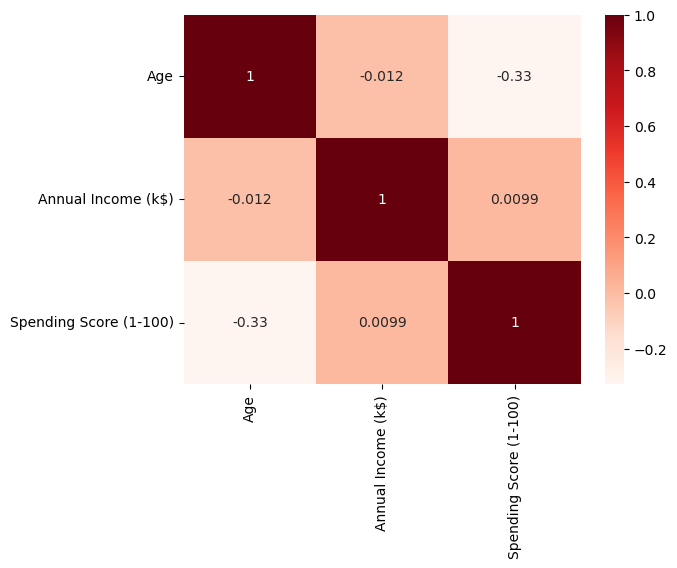

In [19]:
sns.heatmap(correlations,annot=True,cmap='Reds')

##### 3.2.2 Numerical variable -Age

<Axes: xlabel='Age', ylabel='Annual Income (k$)'>

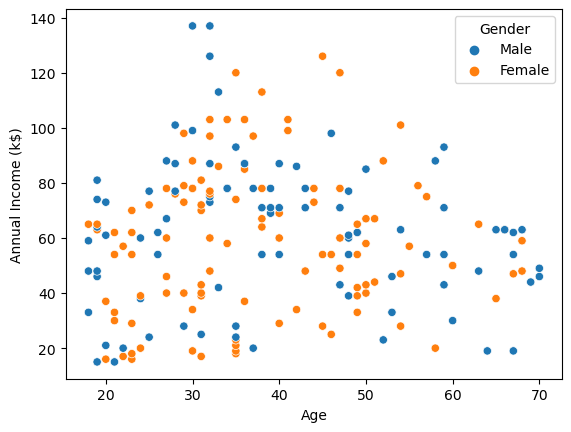

In [20]:
### Scatterplot between Age and Annual Income

sns.scatterplot(data = dataset, x = "Age", y = "Annual Income (k$)", hue = "Gender")

D'après le graphique ci-dessus, nous pouvons constater qu'il n'y a pas de relation significative entre l'âge et le revenu annuel (k$).

<Axes: xlabel='Age', ylabel='Spending Score (1-100)'>

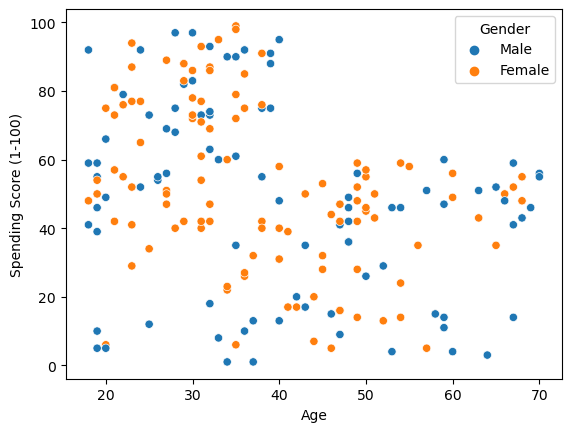

In [21]:
### Scatterplot between Age and Spending Score (1-100)

sns.scatterplot(data = dataset, x = "Age", y = "Spending Score (1-100)", hue = "Gender")

D'après le graphique ci-dessus, nous pouvons constater qu'il n'y a pas de relation significative entre l'âge et le score de dépense (1-100).

##### 3.2.3 Numerical variable - Annual Income (k$)

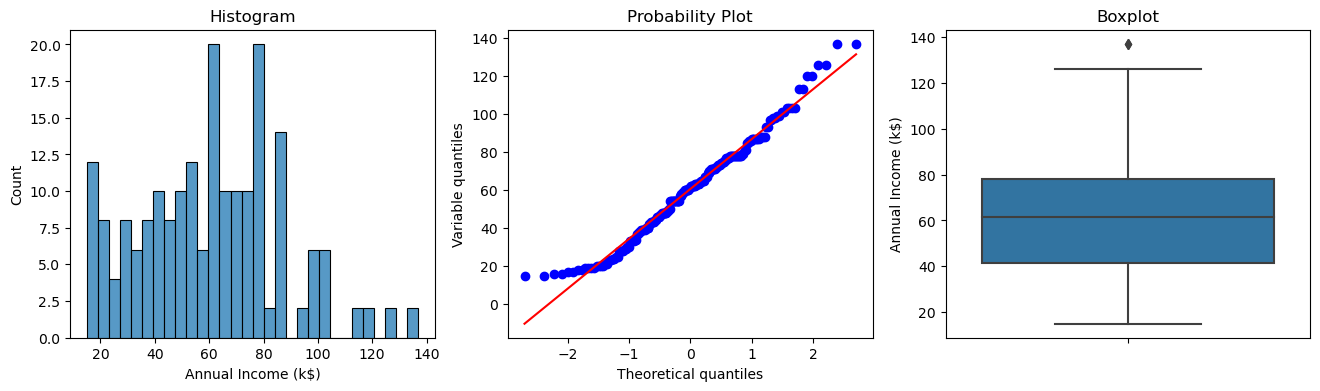

In [22]:
### Understanding the distribution of the column - Annual Income (k$)

diagnostic_plots(dataset, 'Annual Income (k$)')

D'après le graphique ci-dessus, nous pouvons constater que les données présentent un léger degré d'asymétrie ainsi qu'un indice de la présence d'une valeur aberrante.

In [23]:
## Les valeurs aberrantes
outliers = dataset[dataset['Annual Income (k$)'] > 120]
print(outliers)

     CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83


<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

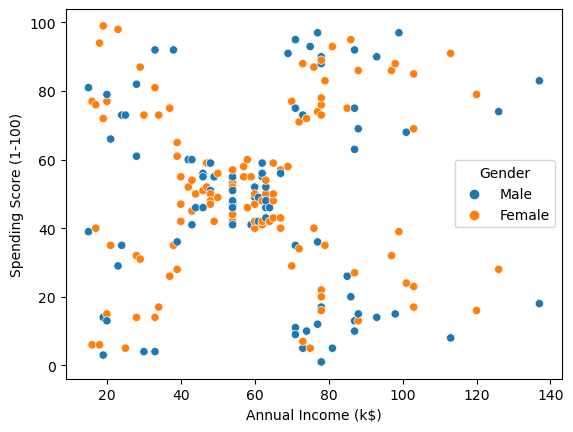

In [24]:
### Scatterplot between Annual Income and Spending Score

sns.scatterplot(data = dataset, x = "Annual Income (k$)", y = "Spending Score (1-100)", hue = "Gender")

D'après le graphique ci-dessus, nous pouvons observer la formation de clusters dans les données. Nous examinerons cela plus en détail en utilisant le clustering K-Means plus tard dans le notebook.

##### 3.2.4 Numerical variable - Spending Score (1-100)

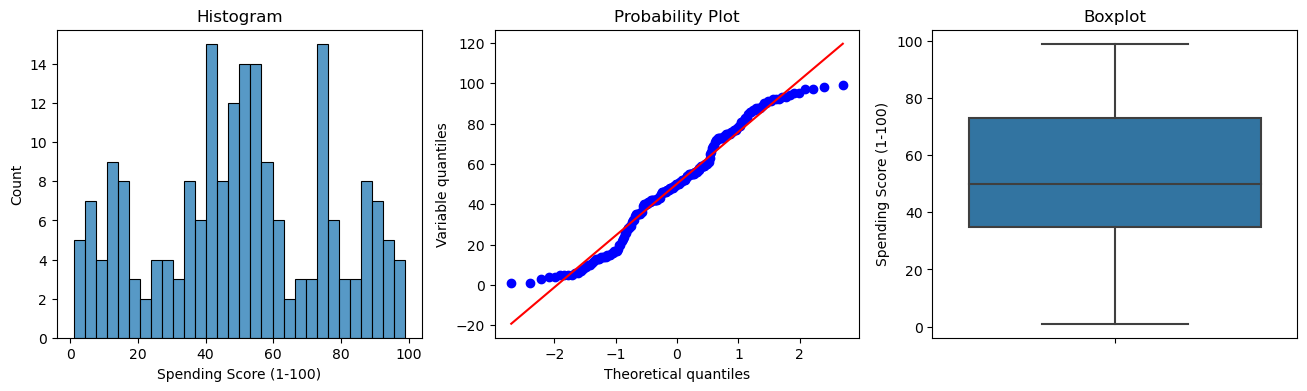

In [25]:
### Understanding the distribution of the column - Spending Score (1-100)

diagnostic_plots(dataset, 'Spending Score (1-100)')

D'après le graphique ci-dessus, nous pouvons constater que les données sont légèrement asymétriques et qu'il n'y a pas de valeurs aberrantes.

# 4. Data preprocessing

La préparation des données (Data preprocessing) est le processus consistant à préparer notre jeu de données pour l'entraînement du modèle. Dans cette section, nous effectuerons les étapes de prétraitement suivantes :

1. Détecter et supprimer les valeurs aberrantes dans les variables numériques
2. Supprimer et remplir les valeurs manquantes

#### 4.1 Detect and remove outliers in numerical variables

Les valeurs aberrantes (outliers) sont des points de données ayant des valeurs extrêmes qui ne correspondent pas à la majorité des données. Il est important de les traiter car elles ont tendance à fausser nos données et peuvent entraîner des prédictions incorrectes du modèle. J'utiliserai la méthode de Tukey pour supprimer ces valeurs aberrantes.

Ici, nous allons écrire une fonction qui parcourra une liste de caractéristiques et détectera les valeurs aberrantes dans chacune de ces caractéristiques. À chaque boucle, un point de données est considéré comme une valeur aberrante s'il est inférieur au premier quartile moins l'étape des valeurs aberrantes, ou s'il dépasse le troisième quartile plus l'étape des valeurs aberrantes. L'étape des valeurs aberrantes est définie comme 1,5 fois l'intervalle interquartile. Une fois les valeurs aberrantes déterminées pour une caractéristique, leurs indices seront stockés dans une liste avant de passer à la caractéristique suivante, et le processus se répète jusqu'à ce que la dernière caractéristique soit terminée. Enfin, en utilisant la liste des indices des valeurs aberrantes, nous compterons les fréquences des indices et les renverrons si leur fréquence dépasse un certain seuil (n fois).

In [26]:
def detect_outliers(df, n, features_list):
    outlier_indices = [] 
    for feature in features_list: 
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(dataset, 2, ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 0 indices:  []


D'après la cellule ci-dessus, nous pouvons constater qu'il n'y a pas de valeurs aberrantes significatives dans le jeu de données.

#### 4.2 Drop and fill missing values

Puisque le jeu de données ne contient pas de valeurs manquantes, nous allons nous concentrer sur la suppression de la colonne de comptage - **CustomerID**.

In [27]:
### Dropping the columns - CustomerId from the dataset

dataset.drop(['CustomerID'], axis = 1, inplace = True)
dataset

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


# 5. Clustering

Ici, nous allons utiliser le K-Means et le clustering hiérarchique pour la segmentation des clients basée sur :

1. L'âge et le score de dépense
2. Le revenu annuel et le score de dépense
3. L'âge, le revenu annuel et le score de dépense

Nous sélectionnerons ensuite le meilleur modèle de segmentation en utilisant les scores Silhouette et Calinski-Harabasz.

#### 5.1 Segmentation using Age and Spending Score (K- Means)

In [28]:
### Filtering the age and spending score from the dataset

X = dataset[['Age', 'Spending Score (1-100)']].iloc[:, :].values

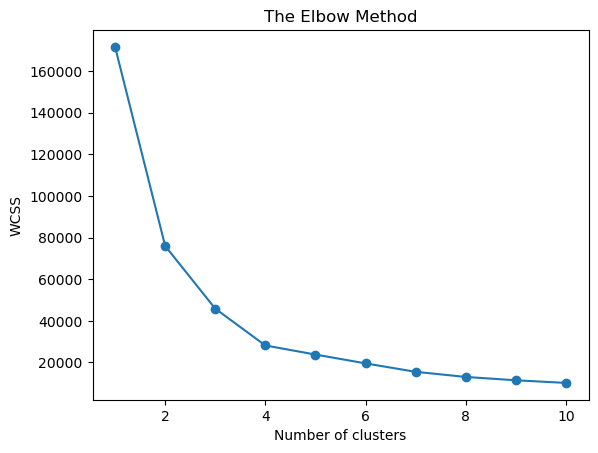

In [29]:
### Using the elbow method to find the optimal number of clusters

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que le nombre optimal de clusters est  3 ou 4.

In [30]:
## determination de la valeur exacte de k optimale selon le methode d'Elbow
from kneed import KneeLocator
k = KneeLocator(range(1,11),wcss,curve='convex',direction ='decreasing')
k.elbow

3

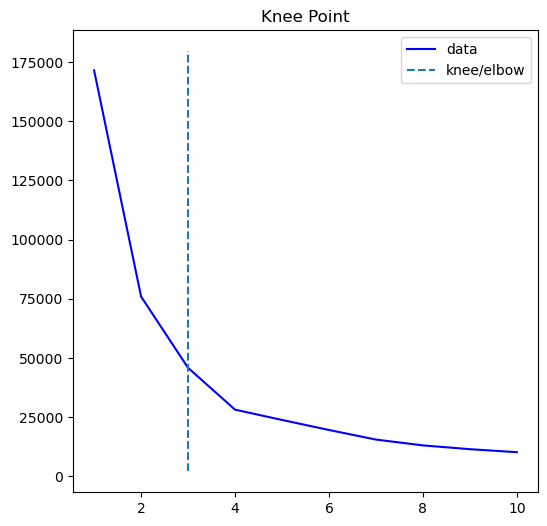

In [31]:
k.plot_knee()

In [32]:
### Training the K-Means model on the dataset

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

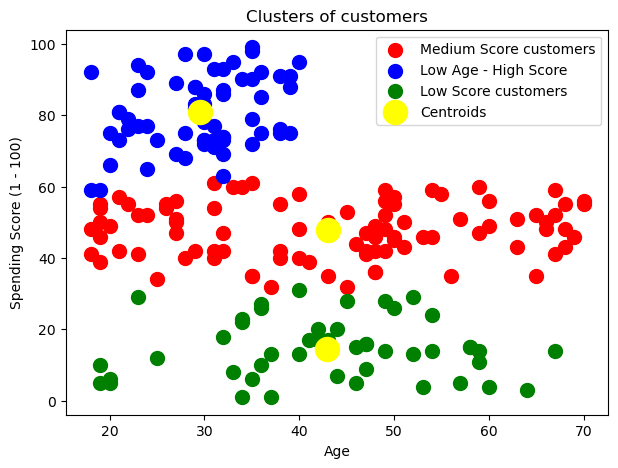

In [33]:
### Visualizing the clusters

plt.figure(figsize = (7, 5))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Medium Score customers')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Low Age - High Score')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Low Score customers')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Age')
plt.ylabel('Spending Score (1 - 100)')
plt.legend()
plt.show()


On remarque que, bien que le nombre optimal de clusters soit égal à 3, le cluster rouge pourrait être divisé en deux sous-clusters distincts : l'un représentant les "low age" (jeunes) et l'autre les "high age" (âgés).

In [34]:
### Training the K-Means model on the dataset

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

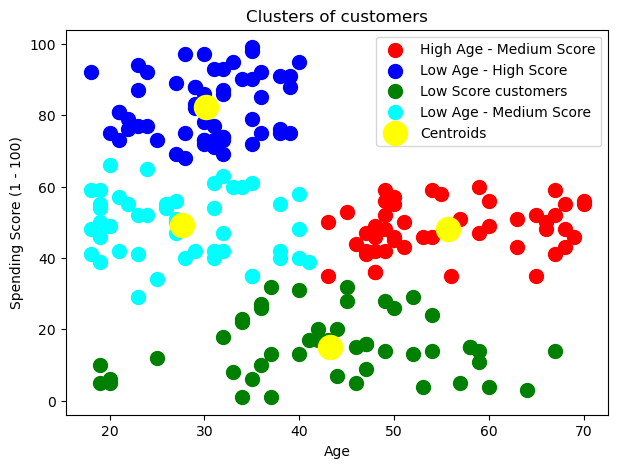

In [35]:
### Visualizing the clusters

plt.figure(figsize = (7, 5))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'High Age - Medium Score')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Low Age - High Score')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Low Score customers')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Low Age - Medium Score')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Age')
plt.ylabel('Spending Score (1 - 100)')
plt.legend()
plt.show()


D'après le graphique ci-dessus, nous pouvons identifier 4 clusters :

1. **Clients âgés avec un score moyen** : Ce cluster regroupe des clients âgés de plus de 40 ans avec un score de dépense compris entre 35 et 60.  
2. **Clients avec un faible score** : Ces clients dépensent très peu dans le centre commercial. L'objectif du centre commercial devrait être de réduire le nombre de clients dans ce cluster (représenté en vert).  
3. **Jeunes clients avec un score élevé** : Ce cluster regroupe des clients âgés de moins de 40 ans ayant un score de dépense supérieur à 70.  
4. **Jeunes clients avec un score moyen** : Ces clients ont moins de 40 ans et un score de dépense compris entre 35 et 65.  

Ce type de segmentation permet de mieux comprendre les différents comportements des clients et d'élaborer des stratégies ciblées pour chaque groupe.

In [36]:
### Calculating the performance of the clusters

silhouette_score_kmeans = round(silhouette_score(X, y_kmeans), 2)
calinski_harabasz_score_kmeans = round(calinski_harabasz_score(X, y_kmeans), 2)

print('Silhouette Score : {}'.format(silhouette_score_kmeans))
print('Calinski Harabasz Score : {}'.format(calinski_harabasz_score_kmeans))

Silhouette Score : 0.5
Calinski Harabasz Score : 332.56


#### 5.2 Segmentation using Age and Spending Score (Hierarchial clustering)

In [37]:
### Filtering the age and spending score from the dataset

X = dataset[['Age', 'Spending Score (1-100)']].iloc[:, :].values

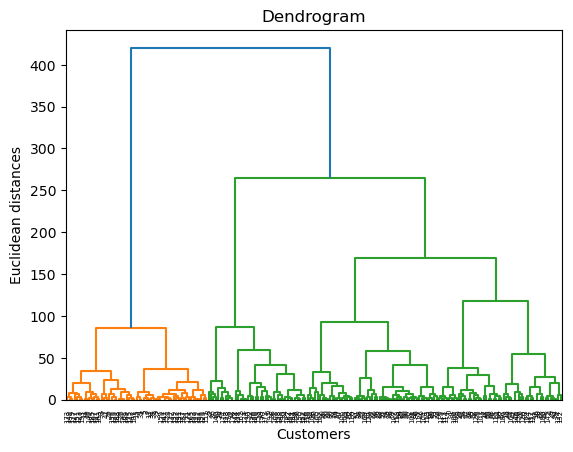

In [38]:
### Using the dendrogram to find the optimal number of clusters

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que le nombre optimal de clusters est 2.

In [39]:
### Training the Hierarchial clustering model on the dataset

hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

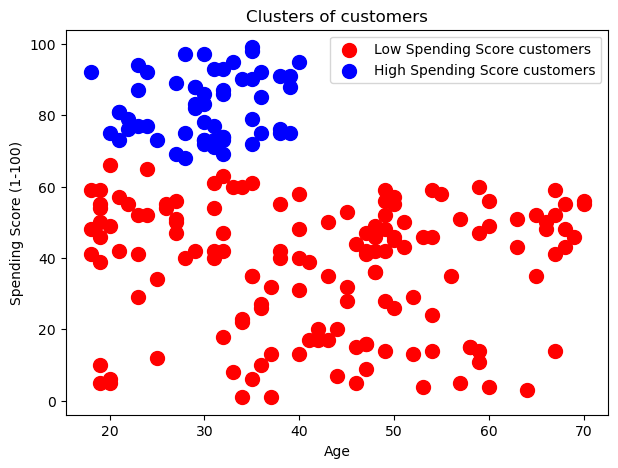

In [40]:
### Visualizing the clusters

plt.figure(figsize = (7, 5))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Low Spending Score customers')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'High Spending Score customers')
plt.title('Clusters of customers')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

D'après le graphique ci-dessus, nous pouvons identifier 2 clusters :

1. **Clients avec un faible score de dépense** : Ce sont les clients ayant un faible score de dépense, comme on peut le voir dans le graphique.  
2. **Clients avec un score de dépense élevé** : Ce sont les clients qui dépensent beaucoup, avec un score de dépense élevé.

Dans un scénario idéal pour le centre commercial, l'objectif serait de réduire le nombre de clients dans le cluster rouge (faible score de dépense) et d'augmenter celui des clients dans l'autre cluster (haut score de dépense). Cela pourrait être accompli en mettant en place des stratégies pour encourager les clients à dépenser davantage.

In [41]:
### Calculating the performance of the clusters

silhouette_score_hc = round(silhouette_score(X, y_hc), 2)
calinski_harabasz_score_hc = round(calinski_harabasz_score(X, y_hc), 2)

print('Silhouette Score : {}'.format(silhouette_score_hc))
print('Calinski Harabasz Score : {}'.format(calinski_harabasz_score_hc))

Silhouette Score : 0.45
Calinski Harabasz Score : 210.56


In [42]:
### Tabulating the results

table = []
print('Segmentation using Age and Spending Score')
table.append(['S.No', 'Clustering Model', 'Silhouette Score', 'Calinski Harabasz Score'])
table.append([1, 'K - Means clustering', silhouette_score_kmeans, calinski_harabasz_score_kmeans])
table.append([2, 'Hierarchial clustering', silhouette_score_hc, calinski_harabasz_score_hc])
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

Segmentation using Age and Spending Score
╒════════╤════════════════════════╤════════════════════╤═══════════════════════════╕
│   S.No │ Clustering Model       │   Silhouette Score │   Calinski Harabasz Score │
╞════════╪════════════════════════╪════════════════════╪═══════════════════════════╡
│      1 │ K - Means clustering   │               0.5  │                    332.56 │
├────────┼────────────────────────┼────────────────────┼───────────────────────────┤
│      2 │ Hierarchial clustering │               0.45 │                    210.56 │
╘════════╧════════════════════════╧════════════════════╧═══════════════════════════╛


D'après le tableau ci-dessus, nous pouvons constater que K-Means donne de meilleurs résultats que le clustering hiérarchique lorsqu'on compare les scores de Silhouette et de Calinski Harabasz.

#### 5.3 Segmentation using Annual Income and Spending Score (K-Means)

In [43]:
### Filtering the annual income and spending score from the dataset

X = dataset[['Annual Income (k$)', 'Spending Score (1-100)']].iloc[:, :].values

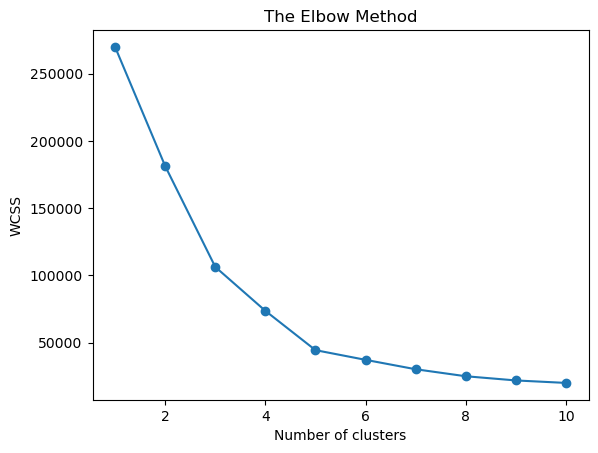

In [44]:
### Using the elbow method to find the optimal number of clusters

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que le nombre optimal de clusters est 5.

In [45]:
## determination de la valeur exacte de k optimale selon le methode d'Elbow
from kneed import KneeLocator
k = KneeLocator(range(1,11),wcss,curve='convex',direction ='decreasing')
k.elbow

5

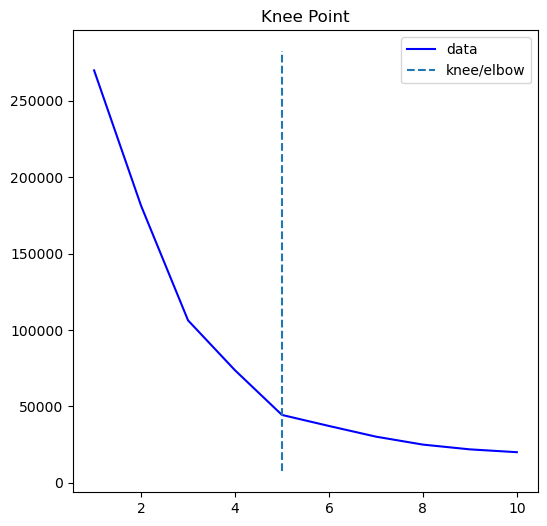

In [46]:
k.plot_knee()

In [47]:
### Training the K-Means model on the dataset

kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

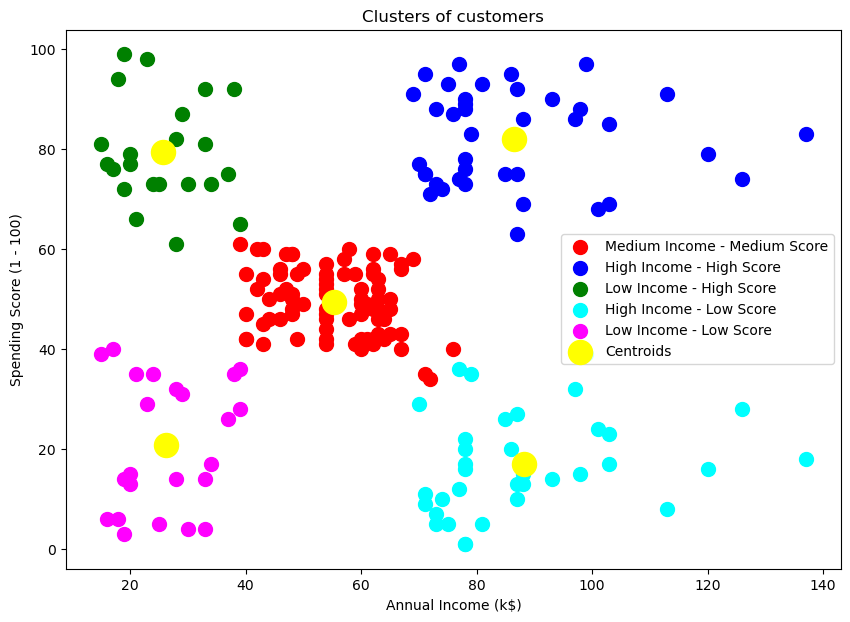

In [48]:
### Visualizing the clusters

plt.figure(figsize = (10, 7))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Medium Income - Medium Score')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'High Income - High Score')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Low Income - High Score')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'High Income - Low Score')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Low Income - Low Score')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1 - 100)')
plt.legend()
plt.show()

D'après le graphique ci-dessus, nous pouvons identifier 5 clusters :

1. **Clients à revenu moyen et score moyen** : Ce cluster regroupe des clients dont le revenu est compris entre 40 et 80 et le score de dépense entre 40 et 60.  
2. **Clients à revenu élevé et score faible** : Ce sont des clients avec un revenu supérieur à 65 et un score de dépense inférieur à 40.  
3. **Clients à faible revenu et score faible** : Ces clients ont un revenu inférieur à 40 et un score de dépense inférieur à 40.  
4. **Clients à faible revenu et score élevé** : Ces clients ont un revenu inférieur à 40 et un score de dépense supérieur à 60.  
5. **Clients à revenu élevé et score élevé** : Ces clients ont un revenu supérieur à 70 et un score de dépense supérieur à 60.

L'objectif du centre commercial est d'augmenter le nombre de clients présents dans le cluster **'Revenu élevé - Score élevé'** en réduisant le nombre de clients dans le cluster **'Revenu élevé - Score faible'**. Il faudrait également encourager les clients du cluster **'Revenu moyen - Score moyen'** à augmenter leur score de dépense.

In [49]:
### Calculating the performance of the clusters

silhouette_score_kmeans = round(silhouette_score(X, y_kmeans), 2)
calinski_harabasz_score_kmeans = round(calinski_harabasz_score(X, y_kmeans), 2)

print('Silhouette Score : {}'.format(silhouette_score_kmeans))
print('Calinski Harabasz Score : {}'.format(calinski_harabasz_score_kmeans))

Silhouette Score : 0.55
Calinski Harabasz Score : 247.36


#### 5.4 Segmentation using Annual Income and Spending Score (Hierarchial clustering)

In [50]:
### Filtering the annual income and spending score from the dataset

X = dataset[['Annual Income (k$)', 'Spending Score (1-100)']].iloc[:, :].values

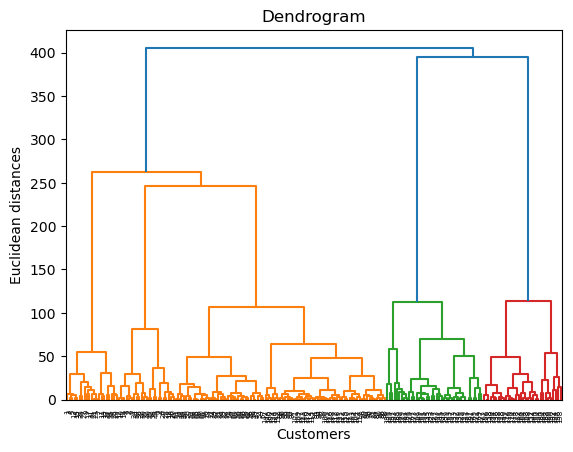

In [51]:
### Using the dendrogram to find the optimal number of clusters

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que le nombre optimal de clusters est 3.

In [52]:
### Training the Hierarchial clustering model on the dataset

hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

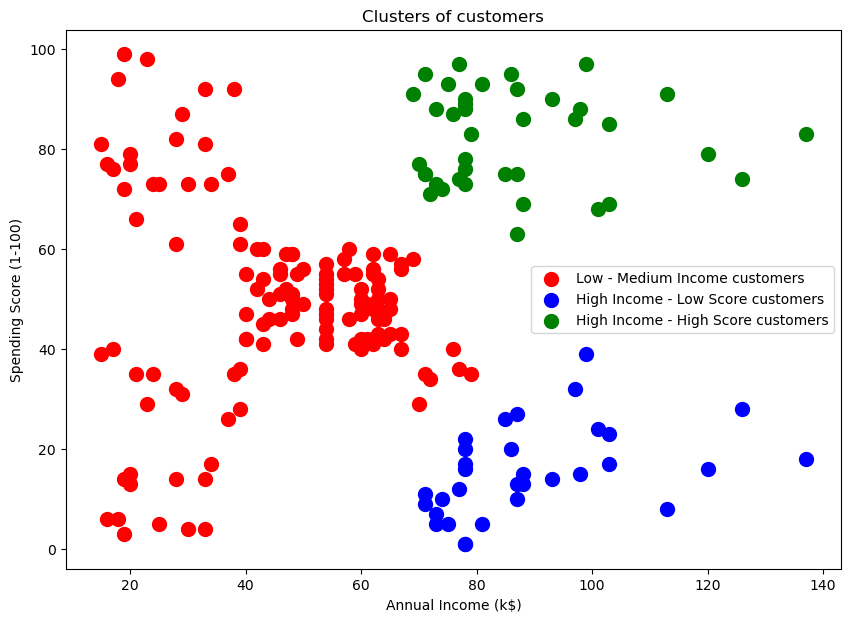

In [53]:
### Visualizing the clusters

plt.figure(figsize = (10, 7))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Low - Medium Income customers')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'High Income - Low Score customers')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'High Income - High Score customers')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

D'après le graphique ci-dessus, nous pouvons identifier 3 clusters :

1. **Clients à revenu faible à moyen** : Ce cluster regroupe des clients dont les revenus sont dans les catégories faibles à moyennes.  
2. **Clients à revenu élevé et score faible** : Ces clients ont un revenu supérieur à 70 et un score de dépense inférieur à 40.  
3. **Clients à revenu élevé et score élevé** : Ce cluster regroupe des clients dont le revenu est supérieur à 70 et le score de dépense supérieur à 60.

L'objectif du centre commercial devrait être d'augmenter le nombre de clients dans le cluster **'Revenu élevé - Score élevé'** en réduisant le nombre de clients dans le cluster **'Revenu élevé - Score faible'**. Par ailleurs, des efforts doivent être faits pour augmenter le score de dépense des clients présents dans le cluster **'Revenu faible à moyen'**.

In [54]:
### Calculating the performance of the clusters

silhouette_score_hc = round(silhouette_score(X, y_hc), 2)
calinski_harabasz_score_hc = round(calinski_harabasz_score(X, y_hc), 2)

print('Silhouette Score : {}'.format(silhouette_score_hc))
print('Calinski Harabasz Score : {}'.format(calinski_harabasz_score_hc))

Silhouette Score : 0.46
Calinski Harabasz Score : 143.82


In [55]:
### Tabulating the results

table = []
print('Segmentation using Annual Income and Spending Score')
table.append(['S.No', 'Clustering Model', 'Silhouette Score', 'Calinski Harabasz Score'])
table.append([1, 'K - Means clustering', silhouette_score_kmeans, calinski_harabasz_score_kmeans])
table.append([2, 'Hierarchial clustering', silhouette_score_hc, calinski_harabasz_score_hc])
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

Segmentation using Annual Income and Spending Score
╒════════╤════════════════════════╤════════════════════╤═══════════════════════════╕
│   S.No │ Clustering Model       │   Silhouette Score │   Calinski Harabasz Score │
╞════════╪════════════════════════╪════════════════════╪═══════════════════════════╡
│      1 │ K - Means clustering   │               0.55 │                    247.36 │
├────────┼────────────────────────┼────────────────────┼───────────────────────────┤
│      2 │ Hierarchial clustering │               0.46 │                    143.82 │
╘════════╧════════════════════════╧════════════════════╧═══════════════════════════╛


D'après le tableau ci-dessus, nous pouvons constater que **K-Means** performe mieux que **le clustering hiérarchique** en comparant les scores **Silhouette** et **Calinski Harabasz**. Cela signifie que le modèle K-Means fournit une meilleure séparation des clusters, ce qui le rend plus adapté pour ce cas d'analyse de segmentation client.

In [56]:
# add cluster label to oiginal data frame
df_cluster = pd.concat([dataset, pd.DataFrame({'Cluster' : y_kmeans})],axis= 1)

In [57]:
df_cluster.head(10)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,4
1,Male,21,15,81,2
2,Female,20,16,6,4
3,Female,23,16,77,2
4,Female,31,17,40,4
5,Female,22,17,76,2
6,Female,35,18,6,4
7,Female,23,18,94,2
8,Male,64,19,3,4
9,Female,30,19,72,2


#### 5.5 Segmentation using Age, Annual Income, and Spending Score (K-Means)

In [58]:
### Filtering the age, annual income and spending score from the dataset

X = dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].iloc[:, :].values

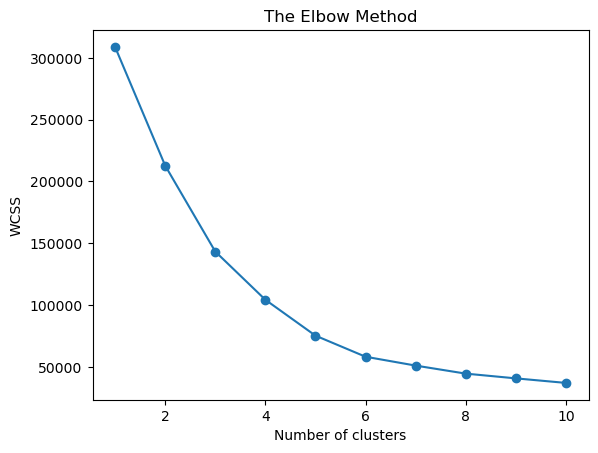

In [59]:
### Using the elbow method to find the optimal number of clusters

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

 D'après le graphique ci-dessus, nous pouvons constater que le **nombre optimal de clusters est 4**.

In [60]:
## determination de la valeur exacte de k optimale selon le methode d'Elbow
from kneed import KneeLocator
k = KneeLocator(range(1,11),wcss,curve='convex',direction ='decreasing')
k.elbow

4

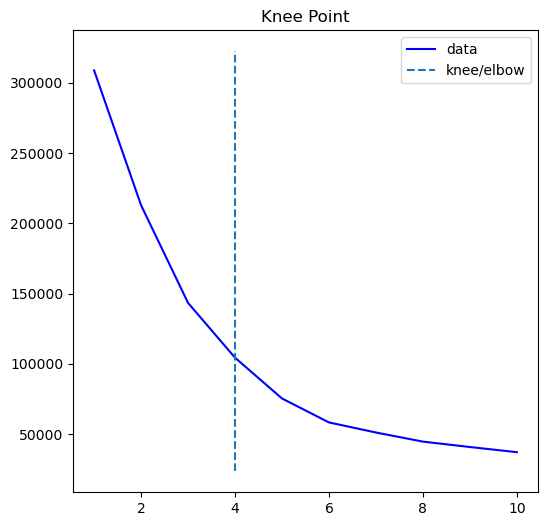

In [61]:
k.plot_knee()

In [62]:
### Training the K-Means model on the dataset

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

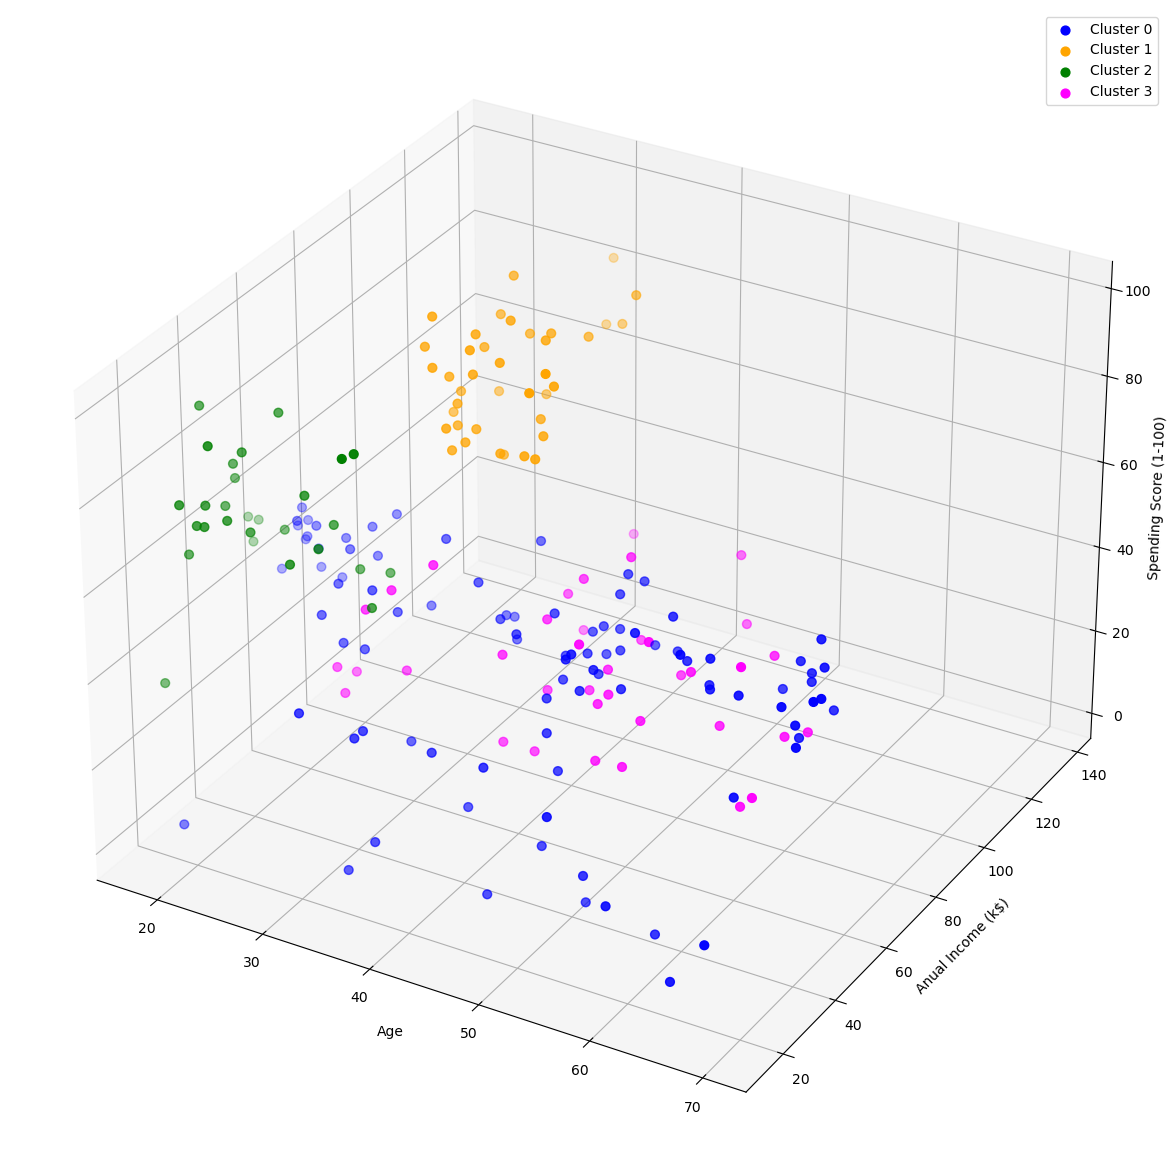

In [63]:
### Visualizing the clusters

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], X[y_kmeans == 0, 2], s = 40 , color = 'blue', label = "Cluster 0")
ax.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], X[y_kmeans == 1, 2], s = 40 , color = 'orange', label = "Cluster 1")
ax.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], X[y_kmeans == 2, 2], s = 40 , color = 'green', label = "Cluster 2")
ax.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], X[y_kmeans == 3, 2], s = 40 , color = 'magenta', label = "Cluster 3")
ax.set_xlabel('Age')
ax.set_ylabel('Anual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.legend()
plt.show()

In [64]:
### Calculating the performance of the clusters

silhouette_score_kmeans = round(silhouette_score(X, y_kmeans), 2)
calinski_harabasz_score_kmeans = round(calinski_harabasz_score(X, y_kmeans), 2)

print('Silhouette Score : {}'.format(silhouette_score_kmeans))
print('Calinski Harabasz Score : {}'.format(calinski_harabasz_score_kmeans))

Silhouette Score : 0.41
Calinski Harabasz Score : 127.98


#### 5.6 Segmentation using Age, Annual Income, and Spending Score (Hierarchial Clustering)

In [65]:
### Filtering the age, annual income and spending score from the dataset

X = dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].iloc[:, :].values

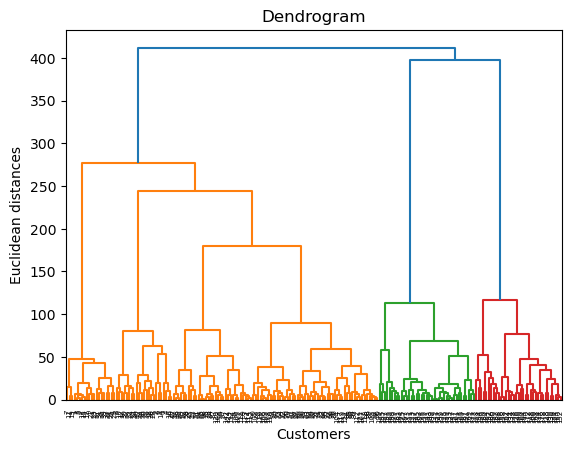

In [66]:
### Using the dendrogram to find the optimal number of clusters

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

D'après le graphique ci-dessus, nous pouvons constater que le **nombre optimal de clusters est 3**.

In [67]:
### Training the Hierarchial clustering model on the dataset

hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

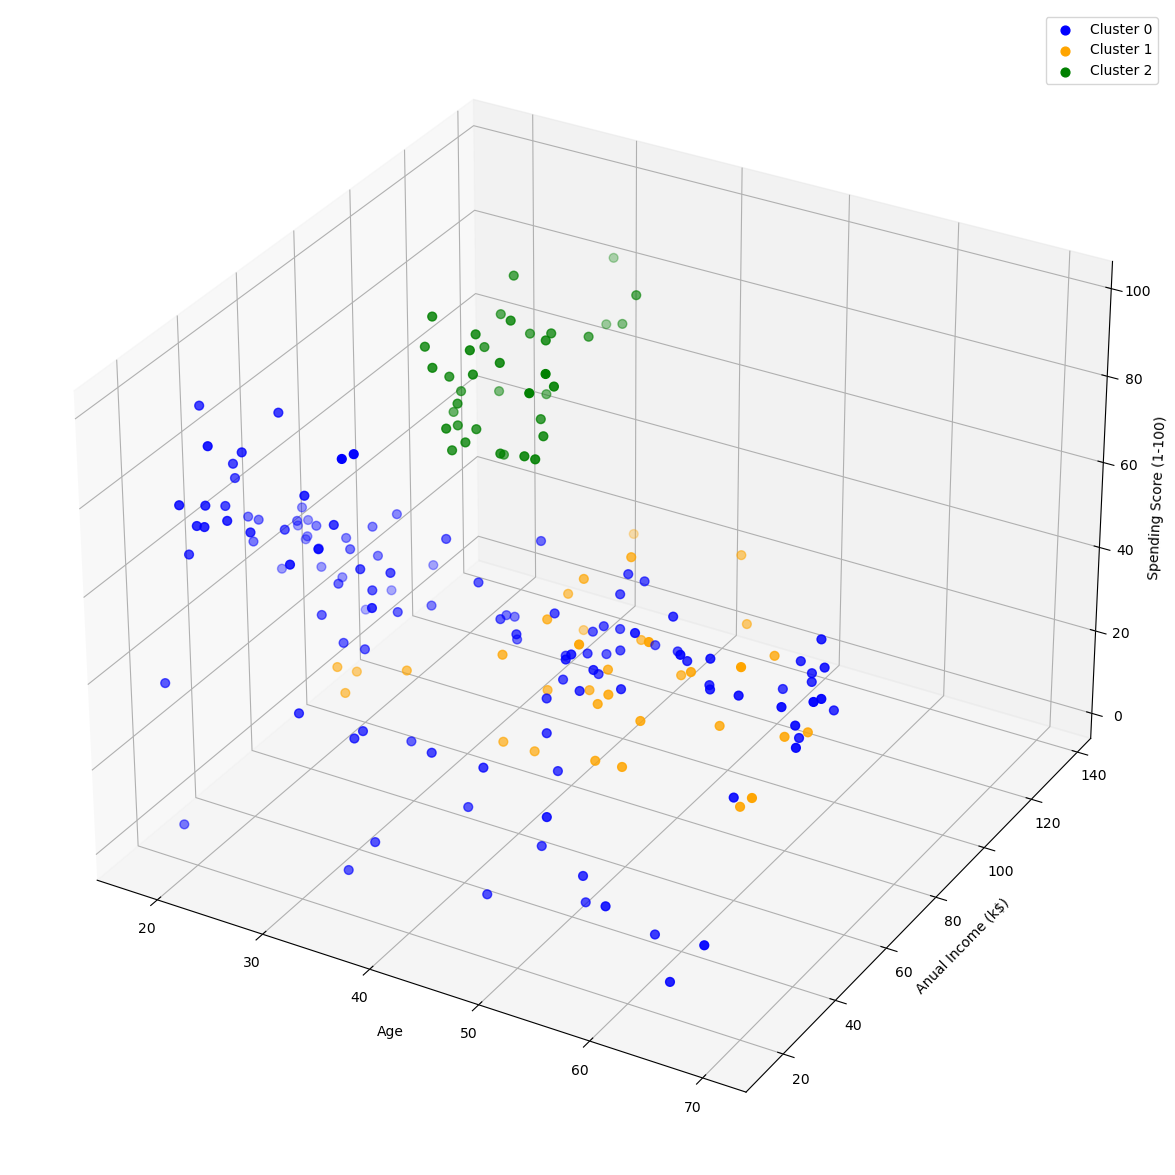

In [68]:
### Visualizing the clusters

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], X[y_hc == 0, 2], s = 40 , color = 'blue', label = "Cluster 0")
ax.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], X[y_hc == 1, 2], s = 40 , color = 'orange', label = "Cluster 1")
ax.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], X[y_hc == 2, 2], s = 40 , color = 'green', label = "Cluster 2")
ax.set_xlabel('Age')
ax.set_ylabel('Anual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.legend()
plt.show()

In [69]:
### Calculating the performance of the clusters

silhouette_score_hc = round(silhouette_score(X, y_hc), 2)
calinski_harabasz_score_hc = round(calinski_harabasz_score(X, y_hc), 2)

print('Silhouette Score : {}'.format(silhouette_score_hc))
print('Calinski Harabasz Score : {}'.format(calinski_harabasz_score_hc))

Silhouette Score : 0.38
Calinski Harabasz Score : 111.46


In [70]:
### Tabulating the results
table = []
print('Segmentation using Age, Annual Income, and Spending Score')
table.append(['S.No', 'Clustering Model', 'Silhouette Score', 'Calinski Harabasz Score'])
table.append([1, 'K - Means clustering', silhouette_score_kmeans, calinski_harabasz_score_kmeans])
table.append([2, 'Hierarchial clustering', silhouette_score_hc, calinski_harabasz_score_hc])
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

Segmentation using Age, Annual Income, and Spending Score
╒════════╤════════════════════════╤════════════════════╤═══════════════════════════╕
│   S.No │ Clustering Model       │   Silhouette Score │   Calinski Harabasz Score │
╞════════╪════════════════════════╪════════════════════╪═══════════════════════════╡
│      1 │ K - Means clustering   │               0.41 │                    127.98 │
├────────┼────────────────────────┼────────────────────┼───────────────────────────┤
│      2 │ Hierarchial clustering │               0.38 │                    111.46 │
╘════════╧════════════════════════╧════════════════════╧═══════════════════════════╛


D'après le tableau ci-dessus, nous pouvons constater que **K-Means** obtient de meilleurs résultats que le **clustering hiérarchique** lorsqu'on compare les scores **Silhouette** et **Calinski Harabasz**. Cela indique que le modèle K-Means offre une séparation plus efficace des clusters, ce qui le rend plus adapté à cette tâche de segmentation.

#### 5.6 Segmentation using Age, Annual Income, and Spending Score with PCA 

In [71]:
pca = PCA(n_components=2)
X = dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].iloc[:, :].values
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_[:2]))

(200, 2)
[0.45125272 0.44098465]
0.892237373550691


On constate que 89,22 % de la variance des données initiales a été préservée dans l’espace réduit à deux dimensions.

Text(0, 0.5, 'PC2')

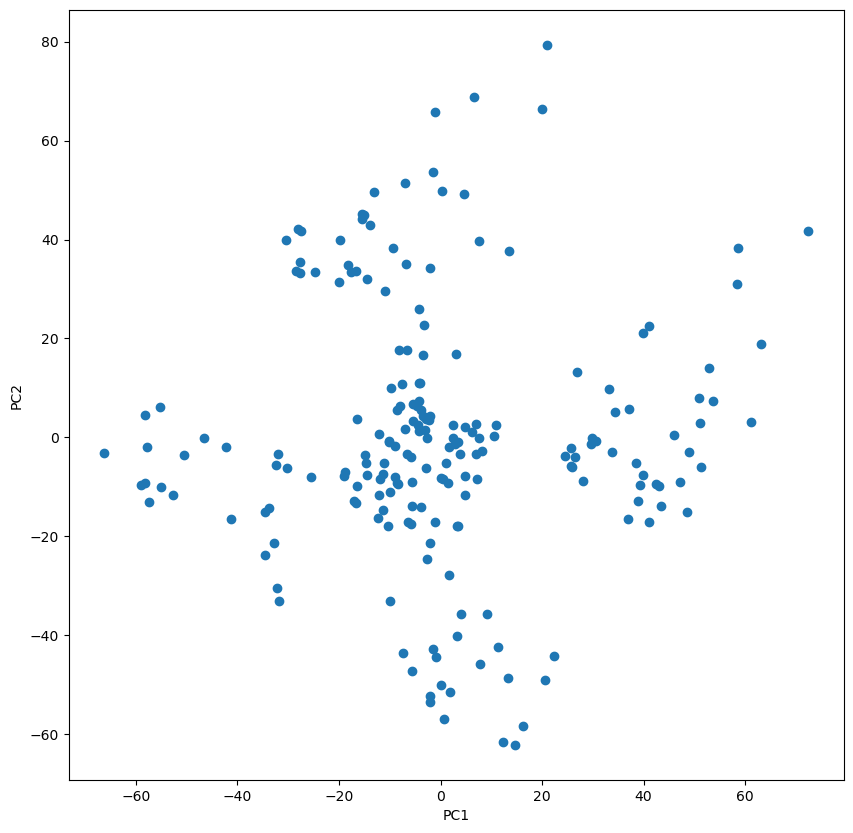

In [72]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

##### K-means dans le nouveau espace

In [77]:
### Training the K-Means model on the dataset

kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_pca)

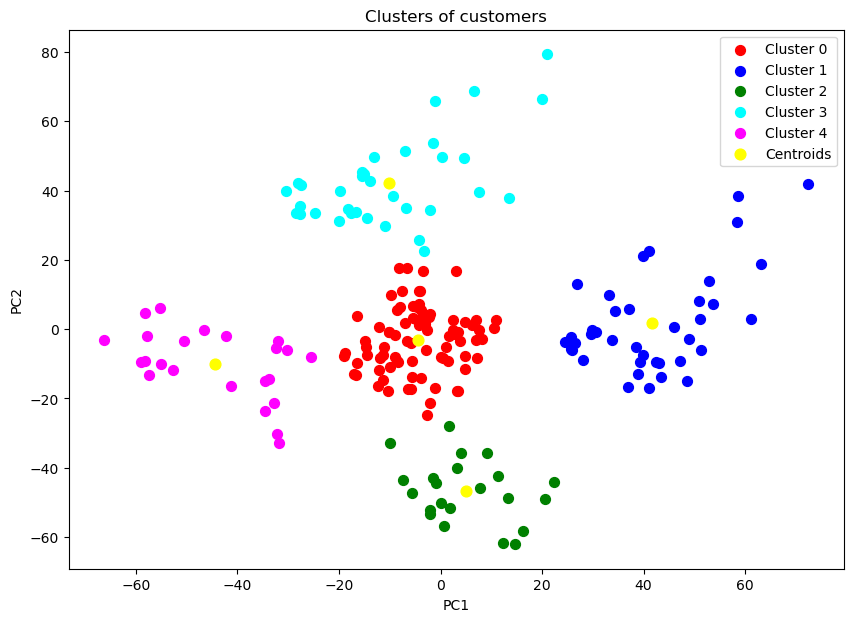

In [78]:
### Visualizing the clusters

plt.figure(figsize = (10, 7))
plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1], s = 50, c = 'red', label = 'Cluster 0')
plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'Cluster 1')
plt.scatter(X_pca[y_kmeans == 2, 0], X_pca[y_kmeans == 2, 1], s = 50, c = 'green', label = 'Cluster 2')
plt.scatter(X_pca[y_kmeans == 3, 0], X_pca[y_kmeans == 3, 1], s = 50, c = 'cyan', label = 'Cluster 3')
plt.scatter(X_pca[y_kmeans == 4, 0], X_pca[y_kmeans == 4, 1], s = 50, c = 'magenta', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 60, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# 6. Conclusion

Ainsi, le **clustering K-Means** aide le centre commercial à mieux comprendre les différents groupes de clients et à identifier des moyens d'améliorer leur score de dépenses, ce qui contribue à augmenter les performances commerciales du centre commercial.

In [2]:
#FIN